'SNS_analysis_total' 폴더가 이미 존재합니다.
데이터 로드 성공!
전처리 완료.
바이그램 분석 시작...


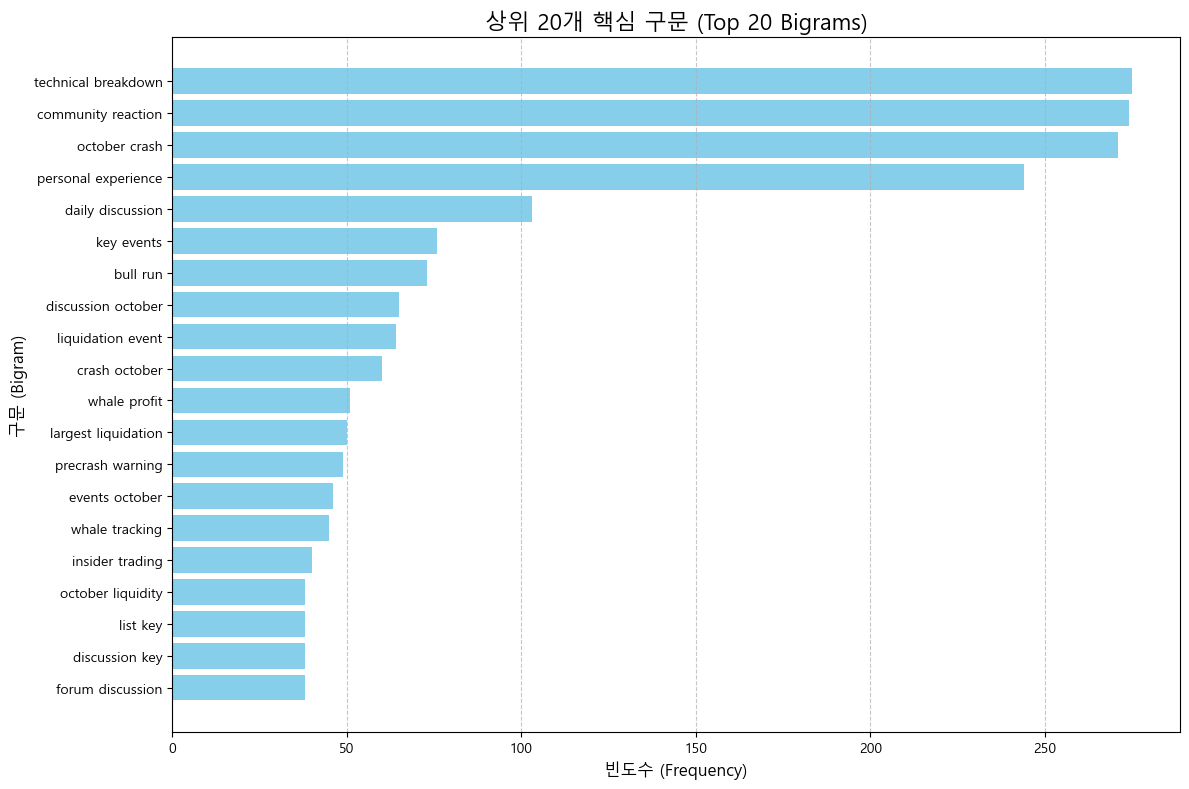

토픽 모델링 시작...


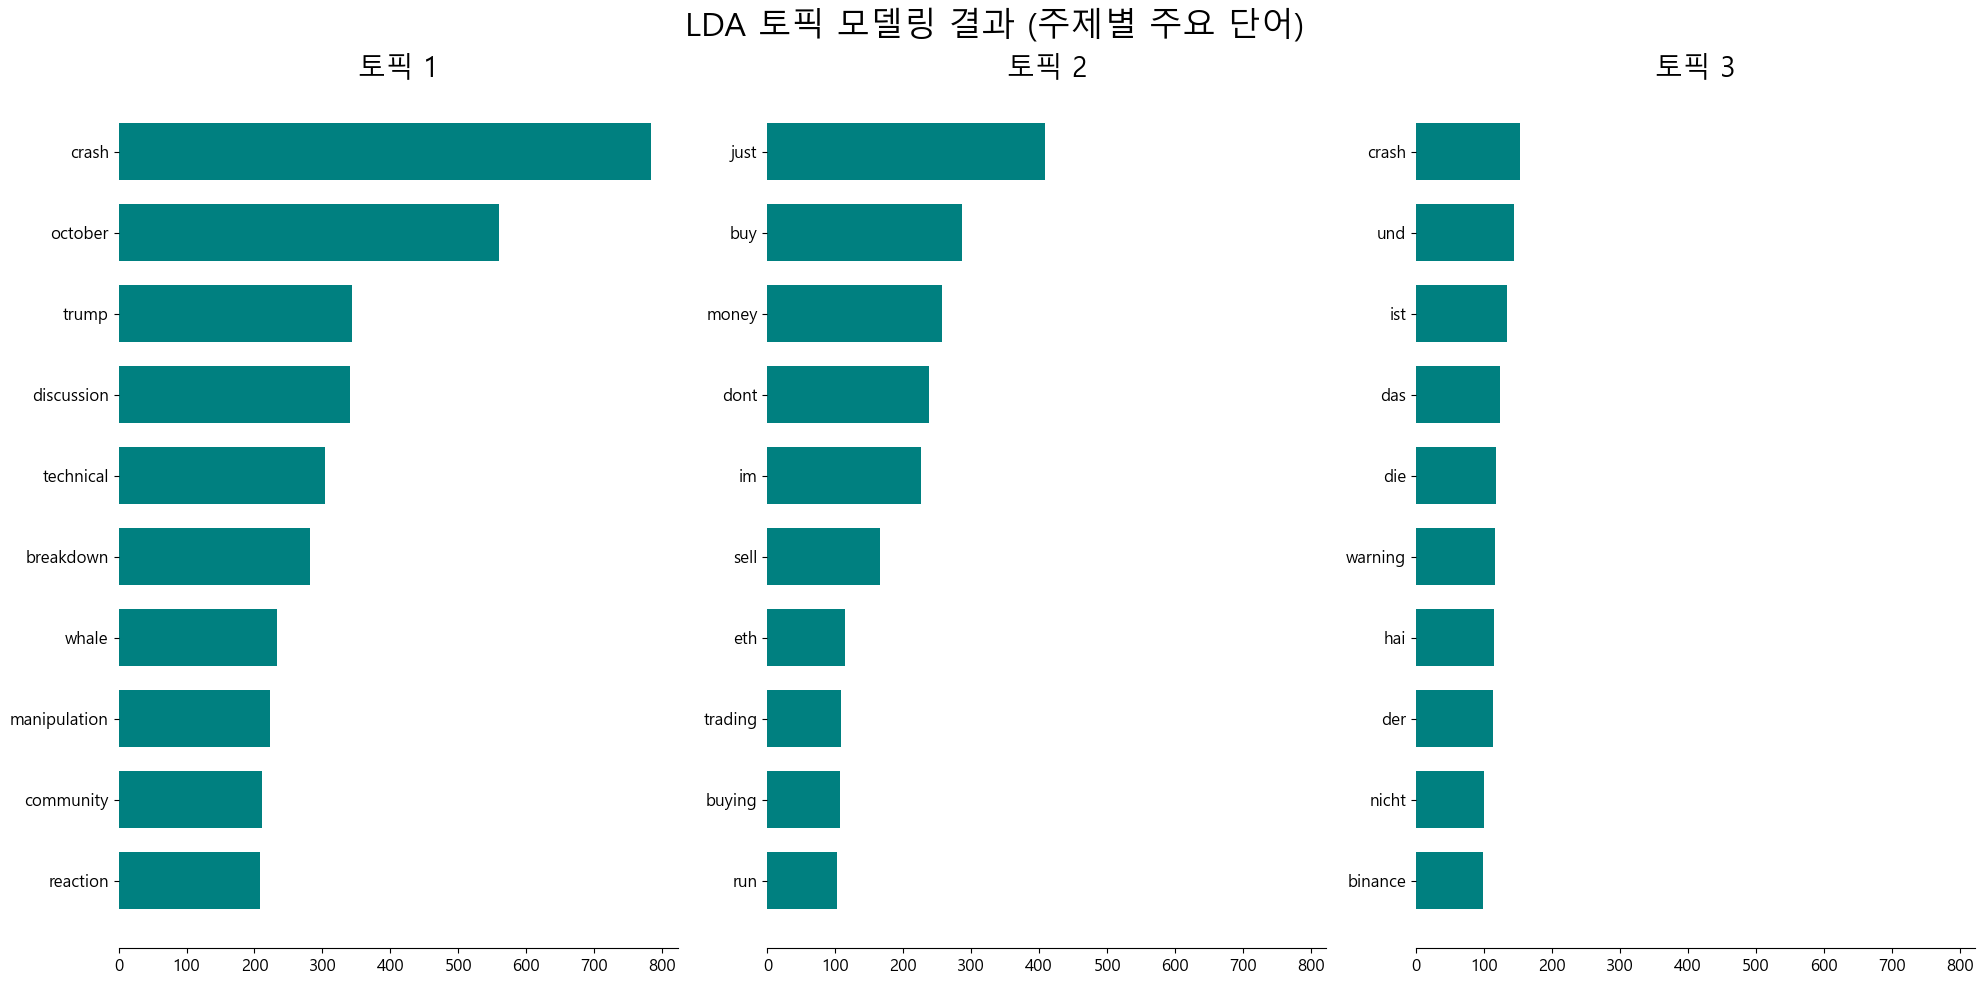

모든 분석이 완료되었습니다


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import platform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob # 감성 분석용 라이브러리
import warnings


# 결과 저장 폴더 생성
output_dir = 'SNS_analysis_total'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"'{output_dir}' 폴더를 생성했습니다.")
else:
    print(f"'{output_dir}' 폴더가 이미 존재합니다.")

# 한글 폰트 설정 (OS 자동 감지)
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic') # Linux 등

plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

# 데이터 로드
try:
    df = pd.read_csv('FINAL_SNS_YOUTUBE.csv')
    print("데이터 로드 성공!")
except FileNotFoundError:
    print("오류: 'FINAL_SNS_YOUTUBE.csv' 파일을 찾을 수 없습니다.")
    # 임시 데이터 생성을 막고 에러 처리

# ==========================================
# 2. 전처리 (Preprocessing)
# ==========================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # 소문자 변환
    text = text.lower()
    # URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # 특수문자 및 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 전처리 적용
df['clean_content'] = df['content'].apply(preprocess_text)

# 빈 내용 제거
df_clean = df[df['clean_content'] != '']

# 불용어 설정 (영어 불용어 + 독일어 및 분석 무의미 단어 추가)
# sklearn의 기본 불용어 목록을 가져와서 확장
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend([
    'warpup', 'wrapup', 'wrap',
    'news', 'report', 'reports', 'reported', 'reporting',
    'analysis', 'analyst', 'analysts',
    'say', 'says', 'said', 'saying', 'according',
    'amid', 'update', 'updates', 'latest',
    'today', 'yesterday', 'tomorrow',
    'time', 'year', 'years', 'week', 'weeks', 'day', 'days', 'month', 'months',
    'people', 'investor', 'investors', 'trader', 'traders',
    'good', 'bad', 'new', 'old', 'great',
    'much', 'many', 'high', 'low', 'big', 'small',
    'million', 'billion',
    'hit', 'hits', 'rise', 'rises', 'rising', 'rose',
    'fall', 'falls', 'falling', 'fell',
    'surge', 'surges', 'surging',
    'drop', 'drops', 'dropping',
    'bitcoin', 'btc', 'crypto', 'cryptocurrency',
    'price', 'prices', 'pricing',
    'market', 'markets',
    'stock', 'stocks',
    'ethereum', 'xrp', 'gold',
    'etf', 'etfs',
    'mining', 'miner',
    'record', 'rally',
    'video', 'channel', 'subscribe', 'link',
    'thank', 'thanks',
    'got', 'get', 'getting',
    'now', 'one', 'use', 'make', 'see', 'look', 'watch',
    'like', 'know', 'think', 'going', 'would', 'could', 'should'
])

print("전처리 완료.")

# ==========================================
# 3. 바이그램 (Bigram) 분석 및 시각화
# ==========================================
print("바이그램 분석 시작...")

# Bigram 벡터화
vectorizer_bi = CountVectorizer(stop_words=custom_stop_words, ngram_range=(2, 2), max_features=20)
X_bi = vectorizer_bi.fit_transform(df_clean['clean_content'])

# 빈도 계산
bi_counts = X_bi.toarray().sum(axis=0)
bi_names = vectorizer_bi.get_feature_names_out()
bi_df = pd.DataFrame({'bigram': bi_names, 'count': bi_counts}).sort_values(by='count', ascending=True)

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(bi_df['bigram'], bi_df['count'], color='skyblue')
plt.title('상위 20개 핵심 구문 (Top 20 Bigrams)', fontsize=16)
plt.xlabel('빈도수 (Frequency)', fontsize=12)
plt.ylabel('구문 (Bigram)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bigram_analysis.png'))
plt.show()

# ==========================================
# 4. LDA 토픽 모델링 (Topic Modeling)
# ==========================================
print("토픽 모델링 시작...")

# LDA용 벡터화 (단어 출현 빈도 기반)
vectorizer_lda = CountVectorizer(stop_words=custom_stop_words, max_features=1000, max_df=0.9, min_df=5)
X_lda = vectorizer_lda.fit_transform(df_clean['clean_content'])

# LDA 모델 학습 (3개 토픽으로 설정)
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(X_lda)

# 토픽별 주요 단어 추출 함수
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='teal')
        ax.set_title(f'토픽 {topic_idx + 1}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=24)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'lda_topics.png'))
    plt.show()

tf_feature_names = vectorizer_lda.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 10, 'LDA 토픽 모델링 결과 (주제별 주요 단어)')

print("모든 분석이 완료되었습니다")

데이터 로딩 중...
분석 대상 기간: 2025-10-01 ~ 2025-10-31
추출된 데이터 수: 5280건
히트맵 생성 중...
저장 완료: SNS_analysis_total\keyword_heatmap_contrast.png


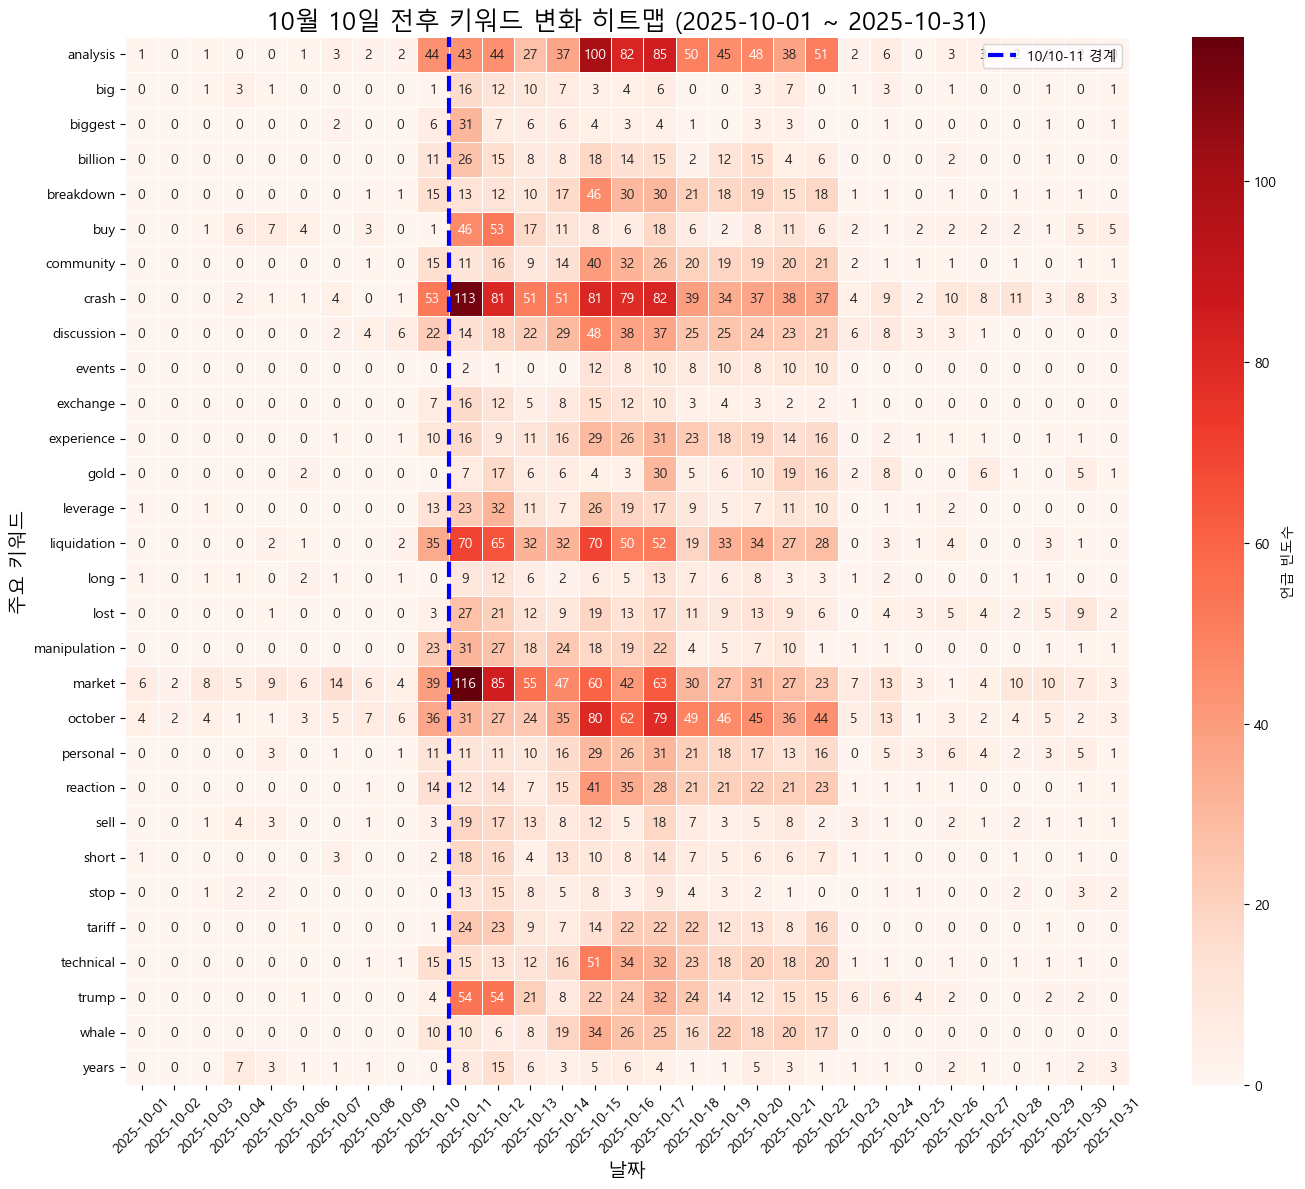

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import font_manager, rc
import platform

# ---------------------------------------------------------
# 1. 환경 설정 (한글 폰트 & 저장 폴더)
# ---------------------------------------------------------
def set_korean_font():
    system_name = platform.system()
    if system_name == 'Windows':
        rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin': # Mac
        rc('font', family='AppleGothic')
    else:
        # Linux/Colab 등
        rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# 결과 저장 폴더
output_dir = 'SNS_analysis_total'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ---------------------------------------------------------
# 2. 데이터 로드 및 전처리
# ---------------------------------------------------------
print("데이터 로딩 중...")
df = pd.read_csv('FINAL_SNS_YOUTUBE.csv')

# 날짜 변환 (Int -> Datetime)
df['date_dt'] = pd.to_datetime(df['date'], format='%Y%m%d')

# ** 핵심: 10월 10일 전후 데이터만 필터링 (10월 1일 ~ 10월 31일) **
start_date = '2025-10-01'
end_date = '2025-10-31'
mask = (df['date_dt'] >= start_date) & (df['date_dt'] <= end_date)
df_focus = df.loc[mask].copy()

print(f"분석 대상 기간: {start_date} ~ {end_date}")
print(f"추출된 데이터 수: {len(df_focus)}건")

# 텍스트 정제 함수
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # URL 제거
    text = re.sub(r'[^\w\s]', '', text) # 특수문자 제거
    text = re.sub(r'\d+', '', text) # 숫자 제거
    text = re.sub(r'\btariffs\b', 'tariff', text) # tariffs => tariff
    text = re.sub(r'\bloss\b', 'lost', text) # loss=> loss
    text = re.sub(r'\bliquidated\b', 'liquidation', text) # liquidated = liquidation
    text = re.sub(r'\bliquidity\b', 'liquidation', text) # liquidity = liquidation
    text = re.sub(r'\bliquidations\b', 'liquidation', text) # liquidations = liquidation
    
    return text.strip()

df_focus['clean_content'] = df_focus['content'].apply(clean_text)

# 불용어 설정 (기존 + 분석에 방해되는 일반적인 단어 추가)
stop_words = list(CountVectorizer(stop_words='english').get_stop_words())
add_stops = ['und', 'die', 'der', 'ist', 'das', 'video', 'youtube', 'just',
             'like', 'dont', 'im', 'know', 'people', 'time', 'think', 'warpup',
             'hai', 'going', 'grokr', 'grokl', 'got', 'thanks', 'bitcoin',
             'moeney', 'sir', 'crypto', 'btc', 'binance', 'se', 'tha',
             'trading', 'xrp', 'eth', 'good', 'did', 'good', 'ke', 'trade', 'year',
             'new', 'que', 'grokc', 'great', 'real', 'best', 'money', 'news',
             'thats', 'nicht', 'day', 'daily', 'es', 'key', 'traders', 'profit',
             'price', 'right', 'run']
stop_words.extend(add_stops)

# ---------------------------------------------------------
# 3. 키워드 추출 및 매트릭스 생성
# ---------------------------------------------------------
# 해당 기간 동안 가장 많이 등장한 상위 30개 단어 추출
cv = CountVectorizer(stop_words=stop_words, max_features=30)
X = cv.fit_transform(df_focus['clean_content'])

# 날짜별로 텍스트를 합침 (Group by Date)
daily_docs = df_focus.groupby(df_focus['date_dt'].dt.strftime('%Y-%m-%d'))['clean_content'].apply(' '.join)

# 날짜별로 다시 카운트 (상위 30개 단어 기준)
# 위에서 뽑은 상위 단어(vocabulary)만 대상으로 다시 셉니다.
cv_daily = CountVectorizer(vocabulary=cv.get_feature_names_out()) 
X_daily = cv_daily.fit_transform(daily_docs)

# 히트맵용 데이터프레임 생성 (행: 키워드, 열: 날짜)
heatmap_data = pd.DataFrame(
    X_daily.toarray().T, # Transpose하여 행을 단어로
    index=cv_daily.get_feature_names_out(),
    columns=daily_docs.index
)

# ---------------------------------------------------------
# 4. 시각화 (Heatmap)
# ---------------------------------------------------------
print("히트맵 생성 중...")
plt.figure(figsize=(14, 12))

# 색상 테마: 'Reds', 'YlOrRd', 'rocket_r' 등 추천
# 10일과 11일의 경계를 잘 보여주기 위해 날짜 라벨을 강조
sns.heatmap(heatmap_data, 
            cmap='Reds',      # 붉은색 계열 (빈도 높을수록 진함)
            linewidths=.5,    # 칸 구분선
            annot=True,       # 숫자 표시 (필요 없으면 False)
            fmt='d',          # 정수 표현
            cbar_kws={'label': '언급 빈도수'})

plt.title(f'10월 10일 전후 키워드 변화 히트맵 ({start_date} ~ {end_date})', fontsize=18)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('주요 키워드', fontsize=14)
plt.xticks(rotation=45)

# 10일과 11일 사이에 강조선 긋기 (시각적 구분)
# 날짜 컬럼 리스트에서 10월 5일의 인덱스를 찾아 그 오른쪽에 선을 그음
dates = list(heatmap_data.columns)
try:
    idx_target = [i for i, d in enumerate(dates) if '10-10' in d][0]
    plt.axvline(x=idx_target + 1, color='blue', linestyle='--', linewidth=3, label='10/10-11 경계')
    plt.legend()
except IndexError:
    pass # 해당 날짜가 없으면 패스

plt.tight_layout()

# 저장
save_path = os.path.join(output_dir, 'keyword_heatmap_contrast.png')
plt.savefig(save_path, dpi=300)
print(f"저장 완료: {save_path}")

plt.show()